In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_openai import AzureChatOpenAI

In [ ]:
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [ ]:
AZURE_API_BASE = "https://oai-lexai-dev.openai.azure.com"
AZURE_API_KEY = ""
AZURE_DEPLOYMENT_NAME = "gpt-4.1"
AZURE_API_VERSION = "2025-01-01-preview"

llm = AzureChatOpenAI(
    azure_endpoint=AZURE_API_BASE,
    openai_api_key=AZURE_API_KEY,
    deployment_name=AZURE_DEPLOYMENT_NAME,
    openai_api_version=AZURE_API_VERSION,
    temperature=0
)

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [ ]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [ ]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_V3Y1mxwNioofuYpn2LPd1t3U',
  'type': 'tool_call'}]

In [ ]:
# State, Nodes, Edges

State: What information do we need to track over the course of the application?
Nodes: How do we want to update this information over the course of the application?
Edges: How do we want to connect these nodes together?

Using messages as state

With these foundations in place, we can now use messages in our graph state.

Let's define our state, MessagesState, as a TypedDict with a single key: messages.

messages is simply a list of messages, as we defined above (e.g., HumanMessage, etc).

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [ ]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built MessagesState!

MessagesState is defined:

With a pre-build single messages key
This is a list of AnyMessage objects
It uses the add_messages reducer
We'll usually use MessagesState because it is less verbose than defining a custom TypedDict, as shown above.

Mostly used that below message state in Chatbot which has same functionality as above

In [ ]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

This message state contain the same functionality with the message key along with appending the message one by one.

In [ ]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='ac853c3d-d9a3-4c09-ae11-e6726dc3563f'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='20e2f658-138e-4eaa-a1bb-9be6c1162425'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='9a9cf25f-aaf0-4846-b642-d082813af1e6')]

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()



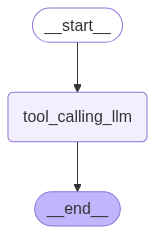

In [ ]:
# View
#display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I help you today?


In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_pAGGS2vO8OTjzreDAfdlZV37)
 Call ID: call_pAGGS2vO8OTjzreDAfdlZV37
  Args:
    a: 2
    b: 3
